In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -q shap
!pip install -q lime
!pip install -q streamlit
!pip install -q xgboost

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df_s = pd.read_csv("leads_dataset.csv")
df_s.head(5)

,Unnamed: 0,Lead_ID,Lead_Type,Marketing_Campaign,Campaign_Type,Campaign_Cost,Attended_Event,Cost_to_Acquire_Lead,Times_Contacted,Days_to_Respond,Engagement_Level,Lead_State,Lead_Acquired
0,0,1,Individual,SpringGrowth,Online,1091.77,1,597.0,5,14,Low,PA,0
1,1,2,Non-Profit,AutumnAwareness,In-Person,3900.21,0,3587.0,1,12,Low,PA,0
2,2,3,Corporate,YearEndPush,Online,2065.00,1,6142.0,6,0,Very High,NC,1
3,3,4,Individual,YearEndPush,Online,2035.61,0,821.0,3,16,Low,NC,0
4,4,5,Individual,SummerSales,In-Person,3398.27,1,10562.0,3,2,Medium,TX,1


In [5]:
df_s.drop(columns = 'Unnamed: 0', inplace = True)

#<font color="lightgreen">1) EDA:</font>

In [6]:
df_s.shape

(10000, 12)

<Axes: xlabel='Lead_Acquired'>

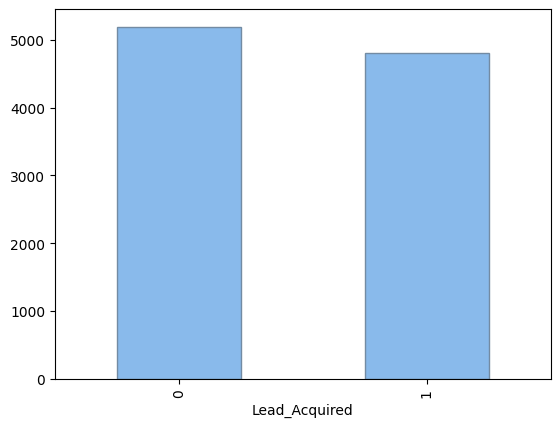

In [7]:
df_s["Lead_Acquired"].value_counts().plot(kind = "bar", edgecolor = "#738BA3", color = "#89BAEB")

In [11]:
df_s[df_s["Lead_Acquired"]==0].describe()

,Lead_ID,Campaign_Cost,Attended_Event,Cost_to_Acquire_Lead,Times_Contacted,Days_to_Respond,Lead_Acquired
count,5193.000000,5193.000000,5193.00000,5193.000000,5193.000000,5193.000000,5193.0
mean,5030.183131,2640.649255,0.48912,2549.248989,3.015790,10.607549,0.0
std,2877.726825,1046.043997,0.49993,1400.964472,1.744168,5.134219,0.0
min,1.000000,629.510000,0.00000,100.000000,0.000000,2.000000,0.0
25%,2526.000000,1895.850000,0.00000,1342.000000,2.000000,6.000000,0.0
50%,5068.000000,2280.600000,0.00000,2560.000000,3.000000,11.000000,0.0
75%,7511.000000,3302.330000,1.00000,3746.000000,4.000000,15.000000,0.0
max,9999.000000,6577.510000,1.00000,4999.000000,11.000000,19.000000,0.0


In [12]:
df_s[df_s["Lead_Acquired"]==1].describe()

,Lead_ID,Campaign_Cost,Attended_Event,Cost_to_Acquire_Lead,Times_Contacted,Days_to_Respond,Lead_Acquired
count,4807.000000,4807.000000,4807.000000,4807.000000,4807.000000,4807.000000,4807.0
mean,4968.433326,2770.636880,0.502392,9354.844186,2.984190,3.488662,1.0
std,2896.725801,1094.748748,0.500046,4504.468430,1.720528,2.276147,0.0
min,3.000000,530.160000,0.000000,1501.000000,0.000000,0.000000,1.0
25%,2473.000000,1932.590000,0.000000,5359.500000,2.000000,2.000000,1.0
50%,4938.000000,2403.360000,1.000000,9473.000000,3.000000,4.000000,1.0
75%,7482.500000,3590.570000,1.000000,13234.000000,4.000000,5.000000,1.0
max,10000.000000,6651.700000,1.000000,16998.000000,11.000000,7.000000,1.0


In [13]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Lead_ID               10000 non-null  int64  
 1   Lead_Type             10000 non-null  object 
 2   Marketing_Campaign    10000 non-null  object 
 3   Campaign_Type         10000 non-null  object 
 4   Campaign_Cost         10000 non-null  float64
 5   Attended_Event        10000 non-null  int64  
 6   Cost_to_Acquire_Lead  10000 non-null  float64
 7   Times_Contacted       10000 non-null  int64  
 8   Days_to_Respond       10000 non-null  int64  
 9   Engagement_Level      10000 non-null  object 
 10  Lead_State            10000 non-null  object 
 11  Lead_Acquired         10000 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 937.6+ KB


<font color="yellow">- Let's
- eliminate columns that have 80%+ missing data
- eliminate rows that have 80%+ missing data
- drop the columns that have the same data
- drop unnecessary columns
- preprocess columns representing cost and engineer new feature based on them
</font>

In [14]:
def preprocess(df):
  df_s.drop(columns = "Lead_ID", inplace = True)
  return df_s
df_s = preprocess(df_s)

In [15]:
df_s.isnull().sum()

Lead_Type               0
Marketing_Campaign      0
Campaign_Type           0
Campaign_Cost           0
Attended_Event          0
Cost_to_Acquire_Lead    0
Times_Contacted         0
Days_to_Respond         0
Engagement_Level        0
Lead_State              0
Lead_Acquired           0
dtype: int64

In [16]:
def preprocess_0(df):
    df["Total_Campaign_Cost"] = df["Campaign_Cost"] + df["Cost_to_Acquire_Lead"]
    df.drop(columns = ["Campaign_Cost", "Cost_to_Acquire_Lead"], inplace = True)
    return df_s
df_s = preprocess_0(df_s)

In [17]:
def preprocess_1(df):
  null_col = df.isnull().mean()
  col_to_drop = null_col[null_col>0.8].index
  df.drop(columns = col_to_drop, inplace = True)
  nul_rows = df.isnull().mean(axis = 1)
  rows_to_drop = nul_rows[nul_rows>0.8].index
  df.drop(index = rows_to_drop, inplace = True)
  same_values = df.apply(lambda i:i.nunique() == 1) # if there is only 1 unique value, meaning all values are the same
  col_w_same_values = same_values[same_values].index.tolist()
  df.drop(columns = col_w_same_values, inplace = True)

  return df

In [19]:
df_s = preprocess_1(df_s)

<font color = "yellow"> - Let's see what type of data our dataset has:</font>

In [20]:
def check_datatype(df):
  df_datetime = df.select_dtypes(include = ["datetime", "datetimetz"])
  df_cat = df[list(set(df)-set(df_datetime))].select_dtypes(include = ["object", "category"])
  df_num = df.select_dtypes(include = ["float", "int"])
  # to make sure all columns were reviewed:
  if len(df_num.columns) + len(df_cat.columns) + len(df_datetime.columns) == len(df.columns):
    print("All columns were reviewed for datatype!")
  else:
    print("Some columns were not reviewed.")

check_datatype(df_s)

All columns were reviewed for datatype!


<font color = "yellow">- Lets'
- combine datetime and df_num in one df_num dataframe
- replace missing categorical values with the "Unknown" values - if any
- replace missing numerical values with the average values - if any
</font>

In [21]:
def preprocess_2(df):
  df_datetime = df.select_dtypes(include = ["datetime", "datetimetz"])
  df_cat = df[list(set(df)-set(df_datetime))].select_dtypes(include = ["object", "category"])
  df_num = df.select_dtypes(include = ["float", "int"])
  df_datetime.dropna(inplace = True)
  df_datetime = df_datetime.applymap(lambda x: np.nan if x < 0 else x)
  df_datetime = df_datetime.apply(lambda col: col.fillna(col[col >= 0].mean()))
  df_num = pd.concat([df_num, df_datetime], axis = 1, join = "inner")
  df_cat.fillna("Unknown", inplace = True)
  unknown_count = df_cat.apply(lambda x: x.str.contains("Unknown", case=False, na=False)).sum().sum()
  for i in df_num.columns:
    df_num[i].fillna(df_num[i].mean(), inplace = True)
  return df, df_num, df_cat, df_datetime

In [22]:
df_s, df_num, df_cat, df_datetime = preprocess_2(df_s)

<font color="yellow">-Let's check for high correlation and p-test in numerical features:</font>

In [23]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df_num)
normalized_df = pd.DataFrame(normalized_data, columns=df_num.columns)
correlation_matrix = normalized_df.corr()

In [24]:
correlation_matrix

,Attended_Event,Times_Contacted,Days_to_Respond,Lead_Acquired,Total_Campaign_Cost
Attended_Event,1.000000,-0.020428,-0.015875,0.013263,0.006516
Times_Contacted,-0.020428,1.000000,0.019594,-0.009112,-0.015188
Days_to_Respond,-0.015875,0.019594,1.000000,-0.662460,-0.474743
Lead_Acquired,0.013263,-0.009112,-0.662460,1.000000,0.708324
Total_Campaign_Cost,0.006516,-0.015188,-0.474743,0.708324,1.000000


In [25]:
answer = []
corr_ = correlation_matrix.copy()
for i in corr_.columns:
    for j in corr_.index:
        if i != j and abs(corr_[i][j]) > 0.75:
            # Check if indices are in ascending order
            if i < j:
                answer.append(f"The high correlation is between {i} and {j} of {round(corr_[i][j],2)}")
            else:
                # Skip if indices are not in ascending order to avoid duplicates
                continue
        else:
            answer.append("No highly correlated numerical features detected.")

if all(val == answer[0] for val in answer):
    print(answer[0])
else:
    for val in set(answer):
        if val != "No highly correlated numerical features detected.":
            print(val)

No highly correlated numerical features detected.


Checking p-values if high correlation spotted:
 
- p-value < 0.05 → Significant (keep the feature if comparing to target, eliminate - if feature to feature)

- p-value > 0.05 → Not significant (feature likely doesn’t matter)

In [26]:
import scipy.stats as stats
p_value_matrix = pd.DataFrame(index=df_num.columns, columns=df_num.columns)

# Calculate p-values for each pair of features
for i in range(len(normalized_df.columns)):
    for j in range(i, len(normalized_df.columns)):
        feature1 = normalized_df.columns[i]
        feature2 = normalized_df.columns[j]
        if feature1 != feature2:
            # Calculate the correlation and p-value
            r, p_value = stats.pearsonr(normalized_df[feature1], normalized_df[feature2])
            p_value_matrix.loc[feature1, feature2] = p_value
            p_value_matrix.loc[feature2, feature1] = p_value  
        else:
            # Diagonal elements (self-correlation) are always 0
            p_value_matrix.loc[feature1, feature2] = np.nan

In [27]:
p_value_matrix

,Attended_Event,Times_Contacted,Days_to_Respond,Lead_Acquired,Total_Campaign_Cost
Attended_Event,NaN,0.041079,0.112422,0.184775,0.514687
Times_Contacted,0.041079,NaN,0.050071,0.362245,0.128842
Days_to_Respond,0.112422,0.050071,NaN,0.0,0.0
Lead_Acquired,0.184775,0.362245,0.0,NaN,0.0
Total_Campaign_Cost,0.514687,0.128842,0.0,0.0,NaN


In [28]:
significant_correlations = []
numerical_features = df_num.columns
for feature1 in numerical_features:
    for feature2 in numerical_features:
        if feature1 != feature2 and p_value_matrix.loc[feature1, feature2] < 0.05:
            significant_correlations.append({
                'Feature1': feature1,
                'Feature2': feature2,
                'Correlation': correlation_matrix.loc[feature1, feature2],
                'P-Value': p_value_matrix.loc[feature1, feature2]
            })

significant_correlations_df = pd.DataFrame(significant_correlations)
filtered_correlations = significant_correlations_df[significant_correlations_df["Feature1"] < significant_correlations_df["Feature2"]].loc[significant_correlations_df["Correlation"]>0.75].sort_values(by = "Correlation")
filtered_correlations

,Feature1,Feature2,Correlation,P-Value


<font color="yellow">-Let's check for high correlation and p-test in categorical features:</font>

In [29]:
import pandas as pd
import itertools
import numpy as np
import scipy.stats as stats

categorical_features = df_cat.columns
cramer_v_matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)
p_value_matrix_cat = pd.DataFrame(index=categorical_features, columns=categorical_features)

# Calculate Cramer's V and p-values for each pair of categorical features
for feature1, feature2 in itertools.combinations(categorical_features, 2):
    contingency_table = pd.crosstab(df_cat[feature1], df_cat[feature2])
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim))

    cramer_v_matrix.loc[feature1, feature2] = cramers_v
    cramer_v_matrix.loc[feature2, feature1] = cramers_v
    p_value_matrix_cat.loc[feature1, feature2] = p_value
    p_value_matrix_cat.loc[feature2, feature1] = p_value

In [30]:
answer = []

for i in cramer_v_matrix.columns:
    for j in cramer_v_matrix.index:
        if i != j and abs(cramer_v_matrix[i][j]) > 0.75:
            # Check if indices are in ascending order
            if i < j:
                answer.append(f"The high correlation is between {i} and {j} of {round(cramer_v_matrix[i][j], 1)}")
            else:
                # Skip if indices are not in ascending order to avoid duplicates
                continue
        else:
            answer.append("No highly correlated categorical features detected.")

# Print the results
if all(val == answer[0] for val in answer):
    print(answer[0])
else:
    for val in set(answer):
        if val != "No highly correlated categorical features detected.":
            print(val)

No highly correlated categorical features detected.


In [31]:
significant_correlations = []
categorical_features = df_cat.columns
for feature1 in categorical_features:
    for feature2 in categorical_features:
        if feature1 != feature2 and p_value_matrix_cat.loc[feature1, feature2] < 0.05:
            significant_correlations.append({
                'Feature1': feature1,
                'Feature2': feature2,
                'Correlation': cramer_v_matrix.loc[feature1, feature2],
                'P-Value': p_value_matrix_cat.loc[feature1, feature2]
            })

significant_correlations_df = pd.DataFrame(significant_correlations)
filtered_correlations = significant_correlations_df[significant_correlations_df["Feature1"] < significant_correlations_df["Feature2"]].loc[significant_correlations_df["Correlation"]>0.75].sort_values(by = "Correlation")
filtered_correlations

,Feature1,Feature2,Correlation,P-Value


In [32]:
from scipy.stats import chi2_contingency

# Apply chi-square test for each categorical feature
for col in df_s.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(df_s[col], df_s['Lead_Acquired'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Feature: {col}, p-value: {p}')

Feature: Lead_Type, p-value: 0.023529633002748872
Feature: Marketing_Campaign, p-value: 0.6401568867730993
Feature: Campaign_Type, p-value: 8.913869979119313e-13
Feature: Engagement_Level, p-value: 2.504008050842918e-40
Feature: Lead_State, p-value: 0.5483842535826777


In [34]:
import pandas as pd
import numpy as np
import scipy.stats as stats

categorical_features = df_cat.columns
class_column = "Lead_Acquired" 
p_value_matrix_cat = pd.DataFrame(index=categorical_features, columns=[class_column])
cramer_v_matrix = pd.DataFrame(index=categorical_features, columns=[class_column])

# Calculate Chi-square p-values and Cramer's V for each categorical feature with respect to the class column
for feature in categorical_features:
    if feature != class_column:
        contingency_table = pd.crosstab(df_cat[feature], df_s[class_column])

        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim))

        p_value_matrix_cat.loc[feature, class_column] = p_value
        cramer_v_matrix.loc[feature, class_column] = cramers_v

In [35]:
cramer_v_matrix

,Lead_Acquired
Marketing_Campaign,0.01589
Lead_State,0.028034
Engagement_Level,0.136807
Campaign_Type,0.074493
Lead_Type,0.027384


<font color="yellow">-Let's check p-test in categorical over numerical features:</font>

In [36]:
numerical_features = df_num.columns
categorical_features = df_cat.columns
p_value_matrix_num_cat = pd.DataFrame(index=categorical_features, columns=numerical_features)
df1 = pd.concat([df_num, df_cat], axis = 1)

for cat_feature in categorical_features:
    for num_feature in numerical_features:
        groups = [group[num_feature].values for name, group in df1.groupby(cat_feature)]
        f_statistic, p_value = stats.f_oneway(*groups)
        p_value_matrix_num_cat.loc[cat_feature, num_feature] = p_value

p_value_matrix_num_cat

,Attended_Event,Times_Contacted,Days_to_Respond,Lead_Acquired,Total_Campaign_Cost
Marketing_Campaign,0.218059,0.771601,0.449932,0.64028,0.089853
Lead_State,0.100794,0.689832,0.38333,0.54859,0.035107
Engagement_Level,0.247711,0.37987,0.0,0.0,0.0
Campaign_Type,0.611421,0.377294,0.000005,0.0,0.0
Lead_Type,0.955592,0.916536,0.745722,0.023523,0.078056


In [37]:
significant_correlations = []
categorical_features = df_cat.columns
numerical_features = df_num.columns
for feature1 in categorical_features:
    for feature2 in numerical_features:
        if feature1 != feature2 and p_value_matrix_num_cat.loc[feature1, feature2] < 0.05:
            significant_correlations.append({
                'Feature1': feature1,
                'Feature2': feature2,
                'P-Value': p_value_matrix_num_cat.loc[feature1, feature2]
            })

significant_correlations_df = pd.DataFrame(significant_correlations)
significant_correlations_df

,Feature1,Feature2,P-Value
0,Lead_State,Total_Campaign_Cost,3.510672e-02
1,Engagement_Level,Days_to_Respond,1.404699e-16
2,Engagement_Level,Lead_Acquired,1.071044e-40
3,Engagement_Level,Total_Campaign_Cost,2.517168e-20
4,Campaign_Type,Days_to_Respond,4.852814e-06
5,Campaign_Type,Lead_Acquired,8.320193e-13
6,Campaign_Type,Total_Campaign_Cost,5.495312e-130
7,Lead_Type,Lead_Acquired,2.352301e-02


<font color = 'yellow'>-Let's one-hot-encode our categorical values:
-Let's concatenate numerical and categorical features:</font>

In [38]:
def proc(*args):
  df_num, df_cat = args
  df_cat = pd.get_dummies(df_cat)
  df_ = pd.concat([df_num, df_cat], axis = 1, join = "inner")
  return df_

In [39]:
df_ = proc(df_num, df_cat)

#<font color="lightgreen"> 2) Building ML:</font>

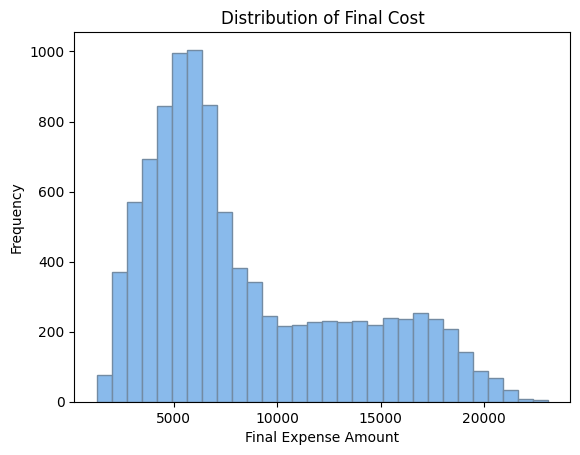

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

final_cost = df_['Total_Campaign_Cost'].dropna()

plt.hist(final_cost, bins=30, edgecolor = "#738BA3", color = "#89BAEB")
plt.title('Distribution of Final Cost')
plt.xlabel('Final Expense Amount')
plt.ylabel('Frequency')
plt.show()

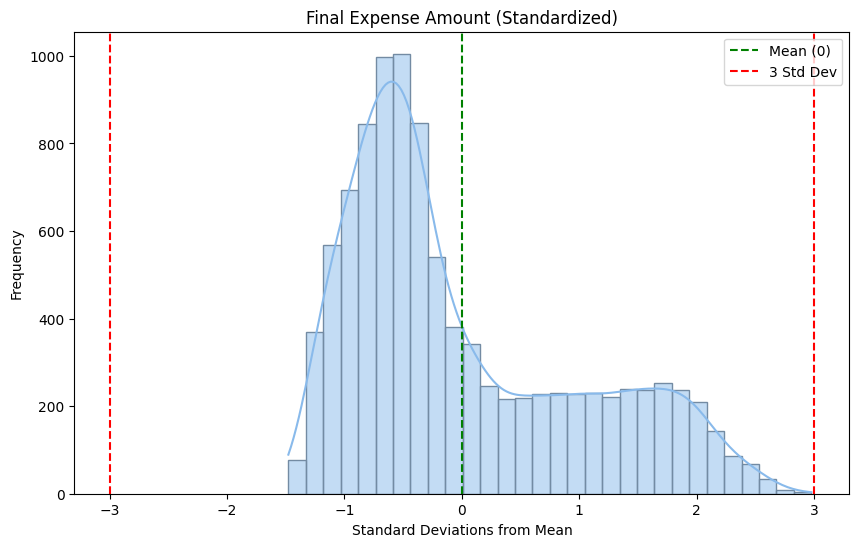

In [41]:
import seaborn as sns
mean = df_['Total_Campaign_Cost'].mean()
std = df_['Total_Campaign_Cost'].std()

plt.figure(figsize=(10, 6))
sns.histplot((df_['Total_Campaign_Cost'] - mean) / std, kde=True, bins=30, edgecolor = "#738BA3", color = "#89BAEB")
plt.axvline(0, color='green', linestyle='--', label='Mean (0)')
plt.axvline(3, color='red', linestyle='--', label='3 Std Dev')
plt.axvline(-3, color='red', linestyle='--')
plt.title('Final Expense Amount (Standardized)')
plt.xlabel('Standard Deviations from Mean')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<font color="yellow">-Let's normalize our data:</font>

In [43]:
df_shuffled = df_.copy()
scaler = StandardScaler()

y = df_shuffled["Lead_Acquired"]
X = df_shuffled.drop(columns = "Lead_Acquired")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

num_features_count = len(X.select_dtypes(include = ["float", "int"]).columns)
X_train_sc = scaler.fit_transform(X_train.iloc[:, 0:num_features_count])
X_test_sc = scaler.transform(X_test.iloc[:, 0:num_features_count])
X_train = np.hstack((X_train_sc, X_train.iloc[:, num_features_count:]))
X_test = np.hstack((X_test_sc, X_test.iloc[:, num_features_count:]))

<font color="lightgreen">-Gaussian NB Models</font>

In [46]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1028
           1       0.90      0.85      0.87       972

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000


Confusion Matrix:
     0    1
0  935   93
1  150  822


<font color="lightgreen">-KNN</font>

In [47]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
print(f'The accuracy score of KNN model is {accuracy:0.2f}')
print()
print(classification_report(y_test, y_pred_knn))
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_knn)))

The accuracy score of KNN model is 0.88

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1028
           1       0.89      0.85      0.87       972

    accuracy                           0.88      2000
   macro avg       0.88      0.87      0.88      2000
weighted avg       0.88      0.88      0.88      2000


Confusion Matrix:
     0    1
0  924  104
1  145  827


<font color="lightgreen">-SVM</font>

<font color="lightgreen">-Different types of SVM: 1. Linear</font>

In [48]:
# Linear Kernel
linear_svm = svm.SVC(kernel='linear')
linear_svm.fit(X_train, y_train)
y_pred_linear = linear_svm.predict(X_test)

print("Linear Kernel SVM")
print(f'Accuracy: {accuracy_score(y_test, y_pred_linear):.2f}')
print(classification_report(y_test, y_pred_linear))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_linear)))

Linear Kernel SVM
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1028
           1       0.91      0.88      0.89       972

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



Confusion Matrix:
     0    1
0  941   87
1  119  853


<font color="lightgreen">-Different types of SVM: 2. Polynomial </font>

In [49]:
# Polynomial Kernel
poly_svm = svm.SVC(kernel='poly', degree=3)  
poly_svm.fit(X_train, y_train)
y_pred_poly = poly_svm.predict(X_test)

print("Polynomial Kernel SVM")
print(f'Accuracy: {accuracy_score(y_test, y_pred_poly):.2f}')
print(classification_report(y_test, y_pred_poly))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_poly)))

Polynomial Kernel SVM
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1028
           1       0.91      0.87      0.89       972

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



Confusion Matrix:
     0    1
0  944   84
1  122  850


<font color="lightgreen">-Different types of SVM: 3. RBF Kernel</font>

In [50]:
# RBF Kernel
rbf_svm = svm.SVC(kernel='rbf')
rbf_svm.fit(X_train, y_train)
y_pred_rbf = rbf_svm.predict(X_test)

print("RBF Kernel SVM")
print(f'Accuracy: {accuracy_score(y_test, y_pred_rbf):.2f}')
print(classification_report(y_test, y_pred_rbf))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_rbf)))

RBF Kernel SVM
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1028
           1       0.92      0.88      0.90       972

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



Confusion Matrix:
     0    1
0  949   79
1  119  853


<font color="lightgreen">-Different types of SVM: 4. Sigmoid Kernel</font>

In [51]:
# Sigmoid Kernel
sigmoid_svm = svm.SVC(kernel='sigmoid')
sigmoid_svm.fit(X_train, y_train)
y_pred_sigmoid = sigmoid_svm.predict(X_test)

print("Sigmoid Kernel SVM")
print(f'Accuracy: {accuracy_score(y_test, y_pred_sigmoid):.2f}')
print(classification_report(y_test, y_pred_sigmoid))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_sigmoid)))

Sigmoid Kernel SVM
Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1028
           1       0.87      0.86      0.86       972

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



Confusion Matrix:
     0    1
0  903  125
1  138  834


<font color="lightgreen">-LR</font>

In [52]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)

print(f'The accuracy score of LR model is {accuracy:0.2f}')
print()
print(classification_report(y_test, y_pred_lr,))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_lr)))

The accuracy score of LR model is 0.89

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1028
           1       0.90      0.88      0.89       972

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



Confusion Matrix:
     0    1
0  934   94
1  119  853


<font color="lightgreen">-LDA</font>

In [53]:
lda_ = LinearDiscriminantAnalysis(solver = "svd")  # Try 'svd'71, 'lsqr'71, or 'eigen'none
lda_.fit(X_train, y_train)
y_pred = lda_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy score of LDA model is {accuracy:0.2f}')
print()
print(classification_report(y_test, y_pred))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))

The accuracy score of LDA model is 0.90

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1028
           1       0.93      0.85      0.89       972

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



Confusion Matrix:
     0    1
0  963   65
1  142  830


<font color="lightgreen">-DT</font>

In [54]:
y = df_shuffled["Lead_Acquired"]
X = df_shuffled.drop(columns = "Lead_Acquired")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

dt = DecisionTreeClassifier(random_state=7)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'The accuracy score of DT model is {accuracy: 0.2f}')
print()
print(classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_dt)))

The accuracy score of DT model is  0.90

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1074
           1       0.88      0.89      0.89       926

    accuracy                           0.90      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.90      0.90      0.90      2000


Confusion Matrix:
     0    1
0  967  107
1  103  823


<font color="lightgreen">-XGBoost</font>

In [55]:
y = df_shuffled["Lead_Acquired"]
X = df_shuffled.drop(columns = "Lead_Acquired")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

num_rounds = 80
bst = xgb.train(params, dtrain, num_rounds)
y_pred = bst.predict(dtest)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred] #checked different thresholds

accuracy = accuracy_score(y_test, y_pred_binary)
print(f'The accuracy score of XGBoost model is {accuracy: 0.2f}')
print()
print(classification_report(y_test, y_pred_binary))
print()
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_binary)))

The accuracy score of XGBoost model is  0.91

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1074
           1       0.92      0.89      0.91       926

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



Confusion Matrix:
      0    1
0  1005   69
1   102  824


<font color="lightgreen">-Random Forest</font>

In [57]:
y = df_shuffled["Lead_Acquired"]
X = df_shuffled.drop(columns = "Lead_Acquired")
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.1, random_state=7)

rf_model = RandomForestClassifier(n_estimators=40, random_state=7)
rf_model.fit(X_train_new, y_train_new)
y_pred_rf = rf_model.predict(X_test_new)

accuracy = accuracy_score(y_test_new, y_pred_rf)
print(f'The accuracy score of Random Forest model is {accuracy: 0.2f}')
print()
print(classification_report(y_test_new, y_pred_rf))
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test_new, y_pred_rf)))

The accuracy score of Random Forest model is  0.90

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       527
           1       0.91      0.86      0.89       473

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.90      1000
weighted avg       0.90      0.90      0.90      1000


Confusion Matrix:
     0    1
0  489   38
1   66  407


#<font color="lightgreen"> 3) Clustering data:</font>

<font color="lightgreen">-Agglomerative Clustering</font>

In [60]:
X_scaled = np.vstack((X_train, X_test))
ac_ = AgglomerativeClustering(n_clusters=5)       
bucket = ac_.fit_predict(X_scaled)
silhouette_avg = silhouette_score(X_scaled, bucket)
       
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.52


#<font color="lightgreen">4) Assigning clusters to our initial dataset:</font>

In [61]:
clust = df_shuffled.copy()
clust["bucket"] = bucket
clusters = {}
for i in range(5):
  clusters[f'clust_{i}'] = clust[clust["bucket"] == i].copy()

#<font color="lightgreen"> 5) Monte Carlo simulation:</font>

In [62]:
np.random.seed(42)
mean = df_shuffled['Total_Campaign_Cost'].mean()
std_dev = df_shuffled['Total_Campaign_Cost'].std()

num_simulations = 1000
random_samples = np.random.normal(mean, std_dev, num_simulations)
random_samples = np.maximum(random_samples, 0)

print(df_shuffled["Total_Campaign_Cost"].min())
print(df_shuffled["Total_Campaign_Cost"].max())

1292.92
23081.95


We will begin by testing all models to identify which one converges to distinct acquisition cost recommendations for each cluster, as this is critical to solving our optimization objective:

In [63]:
def calculate_profit(cost):
    revenue = 25000
    profit_dict = {f'clust_{i}': [] for i in clusters}

    for i in clusters:
        clusters[i]["Total_Campaign_Cost"] = cost
        cluster_data = clusters[i].drop(columns=["bucket", "Lead_Acquired"])
        cluster_scaled_sc = scaler.transform(cluster_data.iloc[:, 0:4])
        cluster_scaled = np.hstack((cluster_scaled_sc, cluster_data.iloc[:, 4:]))

        predicted_matriculation = lda_.predict(cluster_scaled)  # Use your trained model
        leads_accepting = predicted_matriculation.sum()
        profit = leads_accepting * (revenue - cost)
        profit_dict[f'clust_{i}'].append(profit)

    return {cluster: max(profits) for cluster, profits in profit_dict.items()}

# Run simulations for different scholarship amounts
profits = [calculate_profit(cost) for cost in random_samples]

max_values = {}

for idx, profit_dict in enumerate(profits):
    for key, value in profit_dict.items():
        if key not in max_values:
            max_values[key] = {'value': value, 'index': idx}
        else:
            if value > max_values[key]['value']:
                max_values[key] = {'value': value, 'index': idx}

max_values

{'clust_clust_0': {'value': 18830356.3916071, 'index': 790},
 'clust_clust_1': {'value': 31186352.00068979, 'index': 845},
 'clust_clust_2': {'value': 11637301.561547128, 'index': 27},
 'clust_clust_3': {'value': 30240604.38106722, 'index': 363},
 'clust_clust_4': {'value': 10651369.53143577, 'index': 790}}

After the test, LDA Model provided optimized solutions, and we will use it to calculate our predicted cost, lead number and maximized profit for each cluster:

In [64]:
def calculate_profit_1(cost):
    revenue = 25000

    profit_dict = {f'clust_{i}': [] for i in clusters}
    lead_dict = {f'clust_{i}': [] for i in clusters}

    for i in clusters:
        clusters[i]["Total_Campaign_Cost"] = cost
        cluster_data = clusters[i].drop(columns=["bucket", "Lead_Acquired"])

        cluster_scaled_sc = scaler.transform(cluster_data.iloc[:, 0:4])
        cluster_scaled = np.hstack((cluster_scaled_sc, cluster_data.iloc[:, 4:]))

        predicted_lead = lda_.predict(cluster_scaled)

        total_lead = predicted_lead.sum()
        profit = total_lead * (revenue - cost)

        profit_dict[f'clust_{i}'].append(profit)
        lead_dict[f'clust_{i}'].append(total_lead)

    return profit_dict, lead_dict

best_exp = {f'clust_{i}': {'max_profit': -float('inf'), 'total_lead': 0, 'cost': 0} for i in clusters}
for cost in random_samples:
    profit_dict, lead_dict = calculate_profit_1(cost)

    for cluster in profit_dict:
        max_profit = max(profit_dict[cluster])
        if max_profit > best_exp[cluster]['max_profit']:
            best_exp[cluster] = {
                'max_profit': max_profit,
                'total_lead': lead_dict[cluster][0],
                'cost': cost}

#<font color="lightgreen"> 6) Analyzing potential profit vs real profit:</font>

In [65]:
for idx in range(len(best_exp)):
    for buck in clust["bucket"]:
        if idx == buck:
            clust.loc[clust["bucket"] == buck, "predicted_number_of_lead"] = best_exp[f'clust_clust_{idx}']["total_lead"]
            clust.loc[clust["bucket"] == buck, "cost_to_acq"] = best_exp[f'clust_clust_{idx}']["cost"]

clust["earned_profit"] = (25000 - clust["Total_Campaign_Cost"]) * clust["Lead_Acquired"]
clust["predicted_profit"] = (25000 - clust["cost_to_acq"]) * clust["predicted_number_of_lead"] 
profitable = ((clust.groupby("bucket")["predicted_profit"].describe()["max"]-clust.groupby("bucket")["earned_profit"].sum()).loc[clust.groupby("bucket")["predicted_profit"].describe()["max"]-clust.groupby("bucket")["earned_profit"].sum()>=0]).index
deficit = (clust.groupby("bucket")["predicted_profit"].describe()["max"]-clust.groupby("bucket")["earned_profit"].sum()).loc[clust.groupby("bucket")["predicted_profit"].describe()["max"]-clust.groupby("bucket")["earned_profit"].sum()<0]

In [66]:
profitable

Index([0, 1, 2, 3, 4], dtype='int64', name='bucket')

In [67]:
deficit

Series([], dtype: float64)

<font color="yellow"> - let's compare Real Revenue/Exp/Profit to Predicted Revenue/Exp/Profit:

In [68]:
def real_profit_calc():
    filtered_clust = clust[clust["bucket"].isin(profitable.astype(int))]

    # Calculate real revenue, scholarships, and income
    real_revenue = filtered_clust["Lead_Acquired"].sum() * 25000
    real_expense = filtered_clust.loc[filtered_clust["Lead_Acquired"] == 1]["Total_Campaign_Cost"].sum()
    real_income = real_revenue - real_expense

    print(f'The Real Expense: ${real_expense:,.0f}')
    print(f'The Real Profit earned: ${real_income:,.0f}')
    print(f'The Real Revenue earned: ${real_revenue:,.0f}')

    

real_profit_calc()

The Real Expense: $58,287,187
The Real Profit earned: $61,887,813
The Real Revenue earned: $120,175,000


In [69]:
def pred_profit_calc():
    clust_0_prof = clust.loc[clust["bucket"] == 0]["predicted_profit"].iloc[0]
    clust_0_cost = clust.loc[clust["bucket"] == 0]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 0]["predicted_number_of_lead"].iloc[0]
    clust_0_rev = clust.loc[clust["bucket"] == 0]["predicted_number_of_lead"].iloc[0]*25000

    clust_1_prof = clust.loc[clust["bucket"] == 1]["predicted_profit"].iloc[0]
    clust_1_cost = clust.loc[clust["bucket"] == 1]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 1]["predicted_number_of_lead"].iloc[0]
    clust_1_rev =clust.loc[clust["bucket"] == 1]["predicted_number_of_lead"].iloc[0]*25000

    clust_2_prof = clust.loc[clust["bucket"] == 2]["predicted_profit"].iloc[0]
    clust_2_cost = clust.loc[clust["bucket"] == 2]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 2]["predicted_number_of_lead"].iloc[0]
    clust_2_rev =clust.loc[clust["bucket"] == 2]["predicted_number_of_lead"].iloc[0]*25000

    clust_3_prof = clust.loc[clust["bucket"] == 3]["predicted_profit"].iloc[0]
    clust_3_cost = clust.loc[clust["bucket"] == 3]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 3]["predicted_number_of_lead"].iloc[0]
    clust_3_rev =clust.loc[clust["bucket"] == 3]["predicted_number_of_lead"].iloc[0]*25000

    clust_4_prof = clust.loc[clust["bucket"] == 4]["predicted_profit"].iloc[0]
    clust_4_cost = clust.loc[clust["bucket"] == 4]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 4]["predicted_number_of_lead"].iloc[0]
    clust_4_rev =clust.loc[clust["bucket"] == 4]["predicted_number_of_lead"].iloc[0]*25000

    pred_revenue = clust_0_rev + clust_1_rev + clust_2_rev + clust_3_rev + clust_4_rev
    pred_expense = clust_0_cost + clust_1_cost + clust_2_cost + clust_3_cost + clust_4_cost
    pred_income = clust_0_prof + clust_1_prof + clust_2_prof + clust_3_prof + clust_4_prof

    print(f'The Predicted Expense: ${pred_expense:,.0f}')
    print(f'The Predicted Profit: ${pred_income:,.0f}')
    print(f'The Predicted Revenue: ${pred_revenue:,.0f}')

pred_profit_calc()    


The Predicted Expense: $76,129,016
The Predicted Profit: $102,545,984
The Predicted Revenue: $178,675,000


In [70]:
clust["predicted_acq_spent"] = clust["cost_to_acq"] * clust["predicted_number_of_lead"]

#<font color="lightgreen"> 7) Final Conclusive Output:</font>

<font color = "#9901a1ff">**Δ Comparative ROI**</font><font color = "#d1c9d1"> = (($178,675,000-$76,129,016)/$76,129,016)/(($120,175,000-$58,287,187)/$58,287,187) = (1.35-1.06)/1.06 = </font><font color="#63d426">**27.4%**</font>

<font color = "yellow"> - let's see what cost would be asigned for each cluster</font>

In [71]:
def adjust_exp_():
    adjusted_exp = {}

    for i in clust["bucket"].value_counts().index:
        cluster_data = clust.loc[clust["bucket"] == i]
        cluster_data = cluster_data.drop(columns=["bucket", "Lead_Acquired"])
        profit_new = cluster_data["predicted_profit"].sum()/len(cluster_data["predicted_profit"])
        profit_original = cluster_data["earned_profit"].sum()

        # Compare profits and decide on the best scholarship
        if profit_new >= profit_original:
            adjusted_exp[i] = cluster_data["cost_to_acq"].mean()
        else:

            adjusted_exp[i] = cluster_data["Total_Campaign_Cost"].mean()

    return adjusted_exp

adj_exp = adjust_exp_()
adj_exp = pd.DataFrame(data = adj_exp, index = ["Cost"]).T
adj_exp.sort_index(inplace = True)
adj_exp

,Cost
0,10625.682144
1,10933.084348
2,10361.884828
3,10489.153368
4,10625.682144


<Axes: >

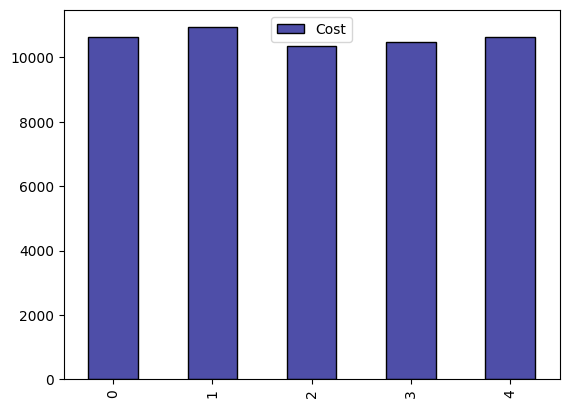

In [72]:
adj_exp.plot(kind="bar", color = "#4E4EA8", edgecolor = "black")

In [ ]:
X

In [82]:
clust.to_csv("clust.csv")
X.to_csv("data_to_test_on.csv", index = False)

In [77]:
with open("lda_.pkl", 'wb') as f1:
    pickle.dump(lda_, f1)

with open("ac_.pkl", 'wb') as f2:
    pickle.dump(ac_, f2)

#<font color="lightgreen"> 8) Streamlit:</font>

In [78]:
import pickle

# Specify the path to your model
model_path1 = 'lda_.pkl'
model_path2 = 'ac_.pkl'

# Load the model
with open(model_path1, 'rb') as file1:
    lda = pickle.load(file1)

with open(model_path2, 'rb') as file2:
    ac = pickle.load(file2)

In [83]:
%%writefile app.py

from sklearn.neighbors import NearestCentroid
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
import math

if "show_treemap" not in st.session_state:
    st.session_state.show_treemap = False

X_ = pd.read_csv("data_to_test_on.csv")
clust = pd.read_csv("clust.csv")
ac = AgglomerativeClustering(n_clusters=5)
bucket = ac.fit_predict(X_)
centroid_model = NearestCentroid()
centroid_model.fit(X_, bucket)


def suggest_cost(cluster):
    if cluster == 0:
        return "$10,626"
    elif cluster == 1:
        return "$10,933"
    elif cluster == 2:
        return "$10,362"
    elif cluster == 3:
        return "$10,489"
    elif cluster == 4:
        return "$10,626"
    else:
        return "No recommendation can be given."


st.markdown(
    """
     <h1 style="
        text-align: center;
        color: rgb(35, 59, 66);">
        Welcome to Your AI Lead Optimizer Advisor!
    </h1>
    """,
    unsafe_allow_html=True,
)

st.write("Please upload your file below to get acquisition cost suggestions.")
uploaded_file = st.file_uploader("Upload Excel or CSV", type=['xlsx', 'csv'])

if uploaded_file:    
    if uploaded_file.name.endswith('.csv'):
        new_data = pd.read_csv(uploaded_file, encoding='utf-8')
    else:
        new_data = pd.read_excel(uploaded_file)

    st.write("Here is a preview of your data:")
    st.write(new_data.head())  

    new_data['Cluster'] = centroid_model.predict(new_data)
    new_data['Cost to Acquire Suggestion'] = new_data['Cluster'].apply(suggest_cost)

    st.write("Here are the results with cluster numbers and acquisition cost suggestions:")
    st.write(new_data[['Cluster', 'Cost to Acquire Suggestion']])

    # Allow user to download the result
    result_file = new_data.to_csv(index=False).encode('utf-8')
    st.download_button(
        label="Download Results as CSV",
        data=result_file,
        file_name='acquisition_cost_recommendations.csv',
        mime='text/csv'
    )


############################################# ALL FUNCTIONS SECTION
####### 
# Times Contacted Distribution
def times_contacted_distribution():
    st.title("Times Contacted Distribution")
    stats = clust.groupby("bucket")["Times_Contacted"].describe()
    selected_buckets = st.multiselect("Select one or more buckets:", stats.index, key="unique_key_for_multiselect")

    if selected_buckets:
        bucket_stats = stats.loc[selected_buckets]
        for bucket, stats_row in bucket_stats.iterrows():
          st.write(f"### Times Contacted Distribution for Bucket: {bucket}")

          q1 = stats_row["25%"]
          q2 = stats_row["50%"]
          q3 = stats_row["75%"]
          min_age = stats_row["min"]
          max_age = stats_row["max"]
          bar_width = 500

          q1_pct = (q1 - min_age) / (max_age - min_age) * 100
          q2_pct = (q2 - min_age) / (max_age - min_age) * 100
          q3_pct = (q3 - min_age) / (max_age - min_age) * 100
           
          st.markdown(
            f"""
            <div style='position: relative; width: {bar_width}px; height: 30px; background: linear-gradient(to right,
            #fff4e6 0%, #ffc48c 25%, #ff7b28 50%, #ff506e 75%, #d923a3 100%);
            border-radius: 15px;'>
                <!-- Marker for 25th percentile (Q1) -->
                <div style='position: absolute; left: {25}%; top: 0; bottom: 0; width: 2px; background-color: #f3fafc;'></div>
                <div style='position: absolute; left: {25}%; top: 35px; font-size: 12px; color: black; text-align: center; transform: translateX(-50%);'>25%</div>
                <!-- Marker for 50th percentile (Median) -->
                <div style='position: absolute; left: {50}%; top: 0; bottom: 0; width: 2px; background-color: #f3fafc;'></div>
                <div style='position: absolute; left: {50}%; top: 35px; font-size: 12px; color: black; text-align: center; transform: translateX(-50%);'>50%</div>
                <!-- Marker for 75th percentile (Q3) -->
                <div style='position: absolute; left: {75}%; top: 0; bottom: 0; width: 2px; background-color: #f3fafc;'></div>
                <div style='position: absolute; left: {75}%; top: 35px; font-size: 12px; color: black; text-align: center; transform: translateX(-50%);'>75%</div>
            </div>
            """, unsafe_allow_html=True)

          # Display Quartile Labels
          st.markdown("<br>", unsafe_allow_html=True)  
          st.markdown("<br>", unsafe_allow_html=True)  
          st.write(f"**Min:** {min_age}")
          st.write(f"**25th Percentile (Q1):** {q1}")
          st.write(f"**50th Percentile (Median):** {q2}")
          st.write(f"**75th Percentile (Q3):** {q3}")
          st.write(f"**Max:** {max_age}")
          st.markdown("<br>", unsafe_allow_html=True)
    else:
      st.write("Please select at least one bucket.")


#######
# Days to Respond Distribution
def days_distribution():
    st.title("Days to Respond Distribution by Bucket")
    selected_buckets2 = st.multiselect("Select one or more buckets:", clust['bucket'].unique(), key="unique_key_for_multiselect2")

    if selected_buckets2:
        selected_data = clust[clust['bucket'].isin(selected_buckets2)]
        fig_width = max(8, len(selected_buckets2) * 1.5)  
        fig, ax = plt.subplots(figsize=(fig_width, 6))
        ax.set_facecolor("#ffffff")

        boxprops = dict(facecolor="#233B42", edgecolor = "#233B42")  
        medianprops = dict(color="white", linestyle=":") 
        flierprops = dict(marker="o", markerfacecolor="#ff506e", markeredgecolor = "#ff506e", markersize=5, linestyle=" ")  
        capprops = dict(color="#233B42", linewidth=1.5)
        whiskerprops = dict(color="#233B42", linewidth=1.5)
        bp = selected_data.boxplot(
        column="Days_to_Respond",
        by="bucket",
        ax=ax,
        boxprops=boxprops,
        medianprops=medianprops,
        flierprops=flierprops,
        capprops = capprops,
        whiskerprops = whiskerprops,
        patch_artist=True)

        ax.grid(False)
        plt.suptitle("")
        plt.suptitle("") 
        ax.set_title("Days to Respond Distribution by Selected Buckets")
        ax.set_xlabel("Bucket")
        ax.set_ylabel("Number of Days")
        st.pyplot(fig)

    else:
        st.write("Please select at least one bucket.")


#######
# Campaign Cost Distribution
def cost_ditribution():
    st.title("Total Campaign Cost by Bucket") 
    selected_buckets4 = st.multiselect(
        "Select one or more buckets:",
        clust['bucket'].unique(),
        key="unique_key_for_multiselect4"
    )

    if selected_buckets4:
        filtered_data = clust[clust['bucket'].isin(selected_buckets4)]
        summary_stats = filtered_data.groupby("bucket")["Total_Campaign_Cost"].agg(
            min_val="min",
            q25_val=lambda x: x.quantile(0.25),
            median_val="median",
            q75_val=lambda x: x.quantile(0.75),
            max_val="max"
        ).reset_index()
        plot_data = summary_stats.set_index("bucket")[["min_val", "q25_val", "median_val", "q75_val", "max_val"]]
        plot_data.columns = ["min", "25%", "50%", "75%", "max"]
        custom_colors = ["#fff4e6", "#ffc48c", "#ff7b28", "#ff506e",  "#d923a3"]

        st.write("Summary statistics for Campaign Cost (Selected Percentiles):")
        num_bars = len(selected_buckets4)

        fig, ax = plt.subplots(figsize=(8, max(2, len(selected_buckets4) * 0.8)))
        ax.set_ylim(-1, len(selected_buckets4) + 0.3)

        summary_stats['y_index'] = range(len(summary_stats))
        for index, row in summary_stats.iterrows():
          y_index = row["y_index"]
          min_val = row["min_val"]
          q25_val = row["q25_val"] - min_val
          median_val = row["median_val"] - row["q25_val"]
          q75_val = row["q75_val"] - row["median_val"]
          max_val = row["max_val"] - row["q75_val"]

          ax.barh(index, min_val, color="#233B42", label="min" if index == 0 else "")
          ax.barh(index, q25_val, left=min_val, color="#ffc48c", label="25%" if index == 0 else "")
          ax.barh(index, median_val, left=row["q25_val"], color="#ff7b28", label="median" if index == 0 else "")
          ax.barh(index, q75_val, left=row["median_val"], color="#ff506e", label="75%" if index == 0 else "")
          ax.barh(index, max_val, left=row["q75_val"], color="#d923a3", label="max" if index == 0 else "")

        ax.set_xlabel('Value')
        ax.set_ylabel('Buckets')
        ax.set_yticks(range(len(selected_buckets4)))
        ax.set_yticklabels([f"Bucket {int(b)}" for b in plot_data.index])
        ax.legend(['min', '25%', '50%', '75%', 'max'], title='Statistics')
        st.pyplot(fig)

        for bucket in selected_buckets4:
            summary_stats = filtered_data.groupby("bucket")["Total_Campaign_Cost"].describe()
            bucket_stats = summary_stats.loc[bucket]
            mean_value = bucket_stats['mean']

            st.write(f"Gauge Chart for Bucket: {bucket}")
            st.write(f"Mean of Campaign Cost: {mean_value:.0f}")

            gauge_chart = go.Figure(go.Indicator(
                mode="gauge+number",
                value=mean_value,
                title={'text': f"Bucket {bucket}: Campaign Cost Mean of {mean_value:.0f}"},

                gauge={
                    'axis': {'range': [None, bucket_stats['max']]},
                    'bar': {'color': "#233B42", 'thickness': 0.5},  # Hide the default bar
                    'steps': [
                        {'range': [0, bucket_stats['25%']], 'color': "#5ACE20"},
                        {'range': [bucket_stats['25%'], bucket_stats['50%']], 'color': "#FFFF33"},
                        {'range': [bucket_stats['50%'], bucket_stats['75%']], 'color': "#FF9A00"},
                        {'range': [bucket_stats['75%'], bucket_stats['max']], 'color': "#FF3C00"}
                    ]
                        }
            ))
            st.plotly_chart(gauge_chart)

    else:
      st.write("Please select one or more buckets to visualize the data.")


#######
# Predicted Profit Calculation
def pred_profit_calc():
    clust_0_prof = clust.loc[clust["bucket"] == 0]["predicted_profit"].iloc[0]
    clust_0_cost = clust.loc[clust["bucket"] == 0]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 0]["predicted_number_of_lead"].iloc[0]
    clust_0_rev = clust.loc[clust["bucket"] == 0]["predicted_number_of_lead"].iloc[0]*25000

    clust_1_prof = clust.loc[clust["bucket"] == 1]["predicted_profit"].iloc[0]
    clust_1_cost = clust.loc[clust["bucket"] == 1]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 1]["predicted_number_of_lead"].iloc[0]
    clust_1_rev =clust.loc[clust["bucket"] == 1]["predicted_number_of_lead"].iloc[0]*25000

    clust_2_prof = clust.loc[clust["bucket"] == 2]["predicted_profit"].iloc[0]
    clust_2_cost = clust.loc[clust["bucket"] == 2]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 2]["predicted_number_of_lead"].iloc[0]
    clust_2_rev =clust.loc[clust["bucket"] == 2]["predicted_number_of_lead"].iloc[0]*25000

    clust_3_prof = clust.loc[clust["bucket"] == 3]["predicted_profit"].iloc[0]
    clust_3_cost = clust.loc[clust["bucket"] == 3]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 3]["predicted_number_of_lead"].iloc[0]
    clust_3_rev =clust.loc[clust["bucket"] == 3]["predicted_number_of_lead"].iloc[0]*25000

    clust_4_prof = clust.loc[clust["bucket"] == 4]["predicted_profit"].iloc[0]
    clust_4_cost = clust.loc[clust["bucket"] == 4]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == 4]["predicted_number_of_lead"].iloc[0]
    clust_4_rev =clust.loc[clust["bucket"] == 4]["predicted_number_of_lead"].iloc[0]*25000

    pred_revenue = clust_0_rev + clust_1_rev + clust_2_rev + clust_3_rev + clust_4_rev
    pred_expense = clust_0_cost + clust_1_cost + clust_2_cost + clust_3_cost + clust_4_cost
    pred_income = clust_0_prof + clust_1_prof + clust_2_prof + clust_3_prof + clust_4_prof

    return pred_expense, pred_income, pred_revenue
pred_profit_calc()    


#######
# Treemap
def plot_treemap():
  df_m = pd.DataFrame(columns=["bucket", "Expense", "Revenue", "Profit", "Profit_check"])
  for i in range(5):
    profit = clust.loc[clust["bucket"] == i]["predicted_profit"].iloc[0]
    exp = clust.loc[clust["bucket"] == i]["cost_to_acq"].iloc[0] * clust.loc[clust["bucket"] == i]["predicted_number_of_lead"].iloc[0]
    revenue = clust.loc[clust["bucket"] == i]["predicted_number_of_lead"].iloc[0]*25000
    profit_check = 0  
    df_m.loc[i] = [i, exp, revenue, profit, profit_check]

  df_map = df_m.copy()
  df_map['bucket_label'] = "Bucket: " + df_map['bucket'].astype(str)
  df_map['profit_label'] = df_map['Profit'].apply(lambda x: f"Predicted Profit: ${x:,.0f}")
  df_map['cost_label'] = df_map['Expense'].apply(lambda x: f"Predicted Cost Acquired: ${x:,.0f}")
  df_map['custom_label'] = df_map['profit_label'] + "<br>" + df_map['cost_label']
  custom_color_scale = [(0, "#d923a3"), (0.025, "#ff506e"), (0.411, "#ff7b28"), (0.954, "#ffc48c"), (1, "#233b42")]

  fig = px.treemap(
       df_map,
       path=['bucket_label'],
       values='Profit',
       color='Profit',  
       color_continuous_scale = custom_color_scale, 
       custom_data=['custom_label']
  )

  fig.update_traces(
      texttemplate="<b>%{label}</b><br>%{customdata[0]}",
      hovertemplate="%{customdata[0]}",
      root_color= "red"
  )

  fig.update_layout(width=1500, height=600, margin=dict(t=50, l=25, r=25, b=25))
  st.plotly_chart(fig, use_container_width=True)


####### 
# Toggle
def toggle_(param):
    e, p, r = pred_profit_calc()    
    if param == "b":      
        return f'${p:,.0f}'
    elif param == "c":
        return f'${e:,.0f}' 
    else:
        return f'${r:,.0f}' 


################################################################################
# Sidebar
with st.sidebar:
  st.sidebar.image("logo_.png", use_container_width = True)
  add_selectbox = st.sidebar.multiselect(
    "**PLEASE SELECT THE TYPE OF ANALYSIS YOU'D LIKE TO REVIEW:**",
    ["Times Contacted Distribution", "Days to Respond Distribution by Bucket", "Total Campaign Cost by Bucket"])

  st.markdown(
        """
        <style>
        /* Hide the sidebar by default */
        [data-testid="stSidebar"] {
            transform: translateX(-100%);
            transition: transform 0.7s ease-in-out;
            background-color: rgb(35, 59, 66);
            color: white;
            overflow-y: auto;
        }

        /* Show the sidebar when hovering over the left edge */
        [data-testid="stAppViewContainer"]:hover [data-testid="stSidebar"],
        [data-testid="stSidebar"].expanded { /* Optional class for expanded state */
        transform: translateX(0%);
        }

        /* Add a small visible edge to hint at the sidebar */
        [data-testid="stAppViewContainer"]::before {
            content: '';
            position: fixed;
            top: 0;
            left: 0;
            width: 5px;
            height: 100%;
            background-color: rgb(35, 59, 66);
            z-index: 1000;
        }

        /* Change the color of the multiselect widget label text */
        [data-testid="stSidebar"] label {
            color: white !important;
        }

        /* Change the color of the text and background in the multiselect widget */
        [data-testid="stSidebar"] .stMultiSelect div[data-baseweb="select"] {
            color: white !important;
        }

        /* Change the dropdown options text color */
        [data-testid="stSidebar"] .stMultiSelect div[data-baseweb="select"] span {
            color: white !important;
            background-color: #ff7b28 !important;
            font-weight: bold !important;
        }

        /* Add space below the multiselect widget */
        [data-testid="stSidebar"] .stMultiSelect {
        margin-bottom: 200px; /* Add space below the multiselect widget */
        }

        </style>
        """,
        unsafe_allow_html=True,
  )

  col1, col2 = st.columns([3, 1])  
  with col1:
    # Clickable phrase styled with HTML and CSS
      st.markdown(
        """
        <style>
        .sidebar-item {
            display: flex;
            align-items: center;
            cursor: pointer;
            margin-top: 14.5px;
            background-color: transparent;
            padding: 0;
            color: white;
            font-size: 20px;
        }

        .sidebar-item .vertical-line {
            border-left: 3px solid white;
            height: 40px;
            margin-right: 10px;
            transition: all 0.3s ease;
        }

        .sidebar-item:hover .vertical-line {
            border-left: 3px solid #ff7b28;
            height: 60px;
        }

        .sidebar-item p {
            margin: 0;
            line-height: 40px;
        }

        .sidebar-item:hover p {
            font-weight: bold;
        }
        </style>
        <div class="sidebar-item" onclick="window.location.href='?link=profit_distribution'">
          <div class="vertical-line"></div>
          <p>Profit per Bucket</p>
        </div>
        """,
        unsafe_allow_html=True,
      )

  with col2:
    st.markdown(
        """
        <style>
        .stToggle div {
            display: flex;
            margin-top: 0px;
            justify-content: flex-start;
            padding: 0px;
            align-items: center; /* Align checkbox vertically */
        }

        </style>
        """,
        unsafe_allow_html=True,
    )
    a = st.toggle("", value=False, key="checkbox_1")

  col3, col4 = st.columns([3, 1]) 
  with col3:
      # Clickable phrase styled with HTML and CSS
    st.markdown(
          """
          <style>
          .sidebar-item {
              display: flex;
              align-items: center;
              cursor: pointer;
              margin-top: 14.5px;
              background-color: transparent;
              padding: 0;
              color: white;
              font-size: 20px;
          }

          .sidebar-item .vertical-line {
              border-left: 3px solid white;
              height: 40px;
              margin-right: 10px;
              transition: all 0.3s ease;
          }

          .sidebar-item:hover .vertical-line {
              border-left: 3px solid #ff7b28;
              height: 60px;
          }

          .sidebar-item p {
              margin: 0;
              line-height: 40px;
          }

          .sidebar-item:hover p {
              font-weight: bold;
          }
          </style>
          <div class="sidebar-item" onclick="window.location.href='?link=profit_distribution'">
            <div class="vertical-line"></div>
            <p>Total Profit per Acquisition Window</p>
          </div>
          """,
          unsafe_allow_html=True,
      )

  with col4:
    st.markdown(
          """
          <style>
          .stToggle div {
              display: flex;
              margin-top: 0px;
              justify-content: flex-start;
              padding: 0px;
              align-items: center; /* Align checkbox vertically */
              height: 40px; /* Matches text height */
          }
          </style>
          """,
          unsafe_allow_html=True,
    )
    b = st.toggle("", value=False, key="checkbox_2")


  col5, col6 = st.columns([3, 1]) 
  with col5:
    # Clickable phrase styled with HTML and CSS
    st.markdown(
          """
          <style>
          .sidebar-item {
              display: flex;
              align-items: center;
              cursor: pointer;
              margin-top: 14.5px;
              background-color: transparent;
              padding: 0;
              color: white;
              font-size: 20px;
          }

          .sidebar-item .vertical-line {
              border-left: 3px solid white;
              height: 40px;
              margin-right: 10px;
              transition: all 0.3s ease;
          }

          .sidebar-item:hover .vertical-line {
              border-left: 3px solid #ff7b28; 
              height: 60px;
          }

          .sidebar-item p {
              margin: 0;
              line-height: 40px;
          }

          .sidebar-item:hover p {
              font-weight: bold;
          }
          </style>
          <div class="sidebar-item" onclick="window.location.href='?link=profit_distribution'">
            <div class="vertical-line"></div>
            <p>Total Expense per Acquisition Window</p>
          </div>
          """,
          unsafe_allow_html=True,
      )

  with col6:
    st.markdown(
        """
        <style>
        .stToggle div {
            display: flex;
            margin-top: 0px;
            justify-content: flex-start;
            padding: 0px;
            align-items: center; /* Align checkbox vertically */
        }

        </style>
        """,
        unsafe_allow_html=True,
    )
    c = st.toggle("", value=False, key="checkbox_3")

  col7, col8 = st.columns([3, 1])  
  with col7:
    # Clickable phrase styled with HTML and CSS
    st.markdown(
          """
          <style>
          .sidebar-item {
              display: flex;
              align-items: center;
              cursor: pointer;
              margin-top: 14.5px;
              background-color: transparent;
              padding: 0;
              color: white;
              font-size: 20px;
          }

          .sidebar-item .vertical-line {
              border-left: 3px solid white;
              height: 40px;
              margin-right: 10px;
              transition: all 0.3s ease;
          }

          .sidebar-item:hover .vertical-line {
              border-left: 3px solid #ff7b28;
              height: 60px;
          }

          .sidebar-item p {
              margin: 0;
              line-height: 40px;
          }

          .sidebar-item:hover p {
              font-weight: bold;
          }
          </style>
          <div class="sidebar-item" onclick="window.location.href='?link=profit_distribution'">
            <div class="vertical-line"></div>
            <p>Total Revenue per Acquisition Window</p>
          </div>
          """,
          unsafe_allow_html=True,
      )

  with col8:
    st.markdown(
        """
        <style>
        .stToggle div {
            display: flex;
            margin-top: 0px;
            justify-content: flex-start;
            padding: 0px;
            align-items: center; /* Align checkbox vertically */
        }

        </style>
        """,
        unsafe_allow_html=True,
    )
    d = st.toggle("", value=False, key="checkbox_4")

if a:
  plot_treemap()

if b:
  total_profit = toggle_("b")
  st.markdown(f'<div class="info-box">Total Profit: {total_profit}</div>', unsafe_allow_html=True)

if c:
  total_exp = toggle_("c")
  st.markdown(f'<div class="info-box">Total Cost: {total_exp}</div>', unsafe_allow_html=True)

if d:
  total_revenue = toggle_("d")
  st.markdown(f'<div class="info-box">Total Revenue: {total_revenue}</div>', unsafe_allow_html=True)

st.markdown(
    """
    <style>
    .info-box {
        background-color: #233B42; /* Blue background */
        color: white; /* White text color */
        border-radius: 10px; /* Rounded edges */
        padding: 20px; /* Padding inside the box */
        text-align: center; /* Center align text */
        font-size: 20px; /* Font size */
        font-weight: bold; /* Bold text */
        box-shadow: 5px 5px 9px rgba( 217, 35, 163, 0.5); /* Subtle shadow */
        width: 300px;
        margin-bottom: 20px;
    }
    </style>
    """,
    unsafe_allow_html=True
)

analysis_functions = {
    "Times Contacted Distribution": times_contacted_distribution, "Days to Respond Distribution by Bucket": days_distribution, "Total Campaign Cost by Bucket": cost_ditribution}

for analysis in add_selectbox:
    analysis_functions[analysis]()

st.markdown(
    """
    <style>
    .footer {
        position: fixed;
        bottom: 0;
        left: 0;
        width: 100%;
        background-color: #F0F0F0;
        color: #333;
        text-align: center;
        padding: 15px;
        font-size: 14px;
        border-top: 1px solid #ccc;
    }
    </style>
    <div class="footer">
        &copy; 2025 Copyright: Christina Trowbridge. All rights reserved.
    </div>
    """,
    unsafe_allow_html=True
)

Overwriting app.py
